Practice training a deep neural network on the CIFAR10 image dataset:
Load CIFAR10 just like you loaded the FashionMNIST dataset in Chapter 10, but using torchvision.datasets.CIFAR10 instead of FashionMNIST. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes.
Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the Swish activation function (using nn.SiLU). Since this is a classification task, you will need an output layer with one neuron per class.
Using NAdam optimization and early stopping, train the network on the CIFAR10 dataset. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.
Now try adding batch-norm and compare the learning curves: is it converging faster than before? Does it produce a better model? How does it affect training speed?
Try replacing batch-norm with SELU, and make the necessary adjustments to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).
Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC dropout.
Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import random_split, DataLoader

In [2]:
trainset = CIFAR10(root='./data', train=True, download=True, 
                   transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

# images, labels = next(iter(train_loader))

# plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0) / 2 + 0.5)
# plt.title(' '.join(trainset.classes[label] for label in labels))
# plt.show()

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

In [4]:
class CifarDNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(n_inputs, n_hidden, device=device))
        self.layers.append(nn.SiLU())
        for i in range(20):
            self.layers.append(nn.Linear(n_hidden, n_hidden, device=device))
            self.layers.append(nn.SiLU())
        self.layers.append(nn.Linear(n_hidden, n_outputs))

    def forward(self, x):
        for layers in self.layers:
            x = layers(x)
        return x

In [5]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_acc = 0
    
    def step(self, val_acc):
        if val_acc > self.best_acc:
            self.best_acc = val_acc
            self.counter = 0
            return False  # do not stop
        else:
            self.counter += 1
            return self.counter >= self.patience  # stop if patience exhausted


In [ ]:
def init_weights_he(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = CifarDNN(3*32*32, 50, 10).to(device)
model.apply(init_weights_he)

CifarDNN(
  (layers): ModuleList(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=50, bias=True)
    (2): SiLU()
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): SiLU()
    (5): Linear(in_features=50, out_features=50, bias=True)
    (6): SiLU()
    (7): Linear(in_features=50, out_features=50, bias=True)
    (8): SiLU()
    (9): Linear(in_features=50, out_features=50, bias=True)
    (10): SiLU()
    (11): Linear(in_features=50, out_features=50, bias=True)
    (12): SiLU()
    (13): Linear(in_features=50, out_features=50, bias=True)
    (14): SiLU()
    (15): Linear(in_features=50, out_features=50, bias=True)
    (16): SiLU()
    (17): Linear(in_features=50, out_features=50, bias=True)
    (18): SiLU()
    (19): Linear(in_features=50, out_features=50, bias=True)
    (20): SiLU()
    (21): Linear(in_features=50, out_features=50, bias=True)
    (22): SiLU()
    (23): Linear(in_features=50, out_features=50, bias=True)
    (24): Si

In [7]:
def accuracy(pred, target):
    preds = pred.argmax(dim=1)
    return (preds == target).float().mean().item()

In [8]:
optimizer = optim.NAdam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopping(patience=4)

In [ ]:
def train(model, optimizer, criterion, epochs, train_loader, val_loader):

    history_train_loss = []
    history_val_loss = []
    # history_train_acc = []
    # history_val_acc = []

    for epoch in range(epochs):

        model.train()
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        for X_batch, y_batch in train_loader:

            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy(preds, y_batch)

        train_loss /= len(train_loader) 
        train_acc /= len(train_loader) 

        model.eval()
        for X_batch, y_batch in val_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad():
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                val_loss += loss.item()
                val_acc += accuracy(preds, y_batch)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}")
        
        history_train_loss.append(train_loss)
        history_val_loss.append(val_loss)
        # history_train_acc.append()
        # history_val_acc.append()

    print("Training finished.")
    return history_train_loss, history_val_loss

In [21]:
history_train_all = []
history_val_all = []

In [22]:
history_train, history_val = train(model, optimizer, criterion, 50, train_loader, val_loader)
history_train_all.append(history_train)
history_val_all.append(history_val)

Epoch 1/50 | Train loss: 1.5613, Train accuracy: 0.4367 |               Val loss: 1.5814 | Val accuracy: 0.4341
Epoch 2/50 | Train loss: 1.5079, Train accuracy: 0.4626 |               Val loss: 1.5742 | Val accuracy: 0.4411
Epoch 3/50 | Train loss: 1.4629, Train accuracy: 0.4792 |               Val loss: 1.5994 | Val accuracy: 0.4401
Epoch 4/50 | Train loss: 1.4285, Train accuracy: 0.4915 |               Val loss: 1.5599 | Val accuracy: 0.4468
Epoch 5/50 | Train loss: 1.3942, Train accuracy: 0.5045 |               Val loss: 1.5360 | Val accuracy: 0.4597
Epoch 6/50 | Train loss: 1.3650, Train accuracy: 0.5159 |               Val loss: 1.5082 | Val accuracy: 0.4723
Epoch 7/50 | Train loss: 1.3380, Train accuracy: 0.5247 |               Val loss: 1.4947 | Val accuracy: 0.4684
Epoch 8/50 | Train loss: 1.3129, Train accuracy: 0.5379 |               Val loss: 1.5485 | Val accuracy: 0.4695
Epoch 9/50 | Train loss: 1.2909, Train accuracy: 0.5430 |               Val loss: 1.4796 | Val accuracy:

In [23]:
class CifarDNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(n_inputs, n_hidden, device=device))
        self.layers.append(nn.BatchNorm1d(n_hidden, device=device))
        self.layers.append(nn.SiLU())
        for i in range(20):
            self.layers.append(nn.Linear(n_hidden, n_hidden, device=device))
            self.layers.append(nn.BatchNorm1d(n_hidden, device=device))
            self.layers.append(nn.SiLU())
        self.layers.append(nn.Linear(n_hidden, n_outputs))

    def forward(self, x):
        for layers in self.layers:
            x = layers(x)
        return x

In [24]:
def init_weights_he(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = CifarDNN(3*32*32, 50, 10).to(device)
model.apply(init_weights_he)

optimizer = optim.NAdam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopping(patience=4)

In [25]:
history_train, history_val = train(model, optimizer, criterion, 50, train_loader, val_loader)
history_train_all.append(history_train)
history_val_all.append(history_val)

Epoch 1/50 | Train loss: 2.1351, Train accuracy: 0.2002 |               Val loss: 2.0142 | Val accuracy: 0.2551
Epoch 2/50 | Train loss: 1.8526, Train accuracy: 0.3251 |               Val loss: 1.7458 | Val accuracy: 0.3693
Epoch 3/50 | Train loss: 1.7025, Train accuracy: 0.3878 |               Val loss: 1.6970 | Val accuracy: 0.3973
Epoch 4/50 | Train loss: 1.6309, Train accuracy: 0.4167 |               Val loss: 1.6042 | Val accuracy: 0.4284
Epoch 5/50 | Train loss: 1.5736, Train accuracy: 0.4357 |               Val loss: 1.6211 | Val accuracy: 0.4254
Epoch 6/50 | Train loss: 1.5326, Train accuracy: 0.4530 |               Val loss: 1.5381 | Val accuracy: 0.4494
Epoch 7/50 | Train loss: 1.4817, Train accuracy: 0.4720 |               Val loss: 1.5335 | Val accuracy: 0.4537
Epoch 8/50 | Train loss: 1.4515, Train accuracy: 0.4810 |               Val loss: 1.4991 | Val accuracy: 0.4703
Epoch 9/50 | Train loss: 1.4149, Train accuracy: 0.4943 |               Val loss: 1.5401 | Val accuracy:

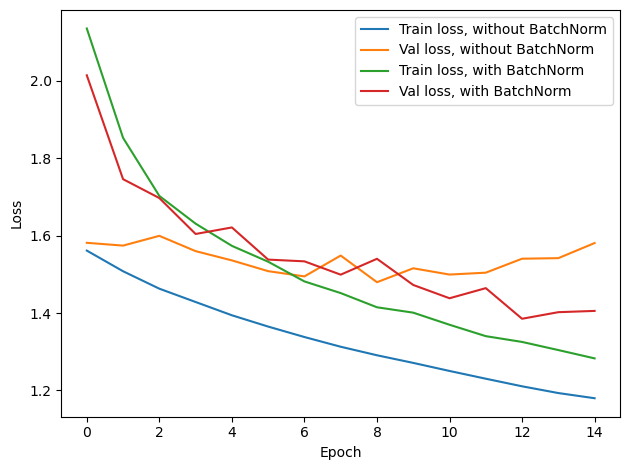

In [29]:
plt.plot(np.arange(len(history_train_all[0][:15])), history_train_all[0][:15], label='Train loss, without BatchNorm')
plt.plot(np.arange(len(history_val_all[0][:15])), history_val_all[0][:15], label='Val loss, without BatchNorm')

plt.plot(np.arange(len(history_train_all[1][:15])), history_train_all[1][:15], label='Train loss, with BatchNorm')
plt.plot(np.arange(len(history_val_all[1][:15])), history_val_all[1][:15], label='Val loss, with BatchNorm')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()

In [30]:
class CifarDNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(n_inputs, n_hidden, device=device))
        self.layers.append(nn.SELU())
        for i in range(20):
            self.layers.append(nn.Linear(n_hidden, n_hidden, device=device))
            self.layers.append(nn.SELU())
        self.layers.append(nn.Linear(n_hidden, n_outputs))

    def forward(self, x):
        for layers in self.layers:
            x = layers(x)
        return x
    
def init_weights_he(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = CifarDNN(3*32*32, 50, 10).to(device)
model.apply(init_weights_he)

optimizer = optim.NAdam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopping(patience=4)

In [31]:
history_train, history_val = train(model, optimizer, criterion, 50, train_loader, val_loader)
history_train_all.append(history_train)
history_val_all.append(history_val)

Epoch 1/50 | Train loss: 2.2849, Train accuracy: 0.2108 |               Val loss: 2.1565 | Val accuracy: 0.2360
Epoch 2/50 | Train loss: 1.9079, Train accuracy: 0.2922 |               Val loss: 1.9050 | Val accuracy: 0.2888
Epoch 3/50 | Train loss: 1.8121, Train accuracy: 0.3387 |               Val loss: 1.8666 | Val accuracy: 0.3137
Epoch 4/50 | Train loss: 1.7384, Train accuracy: 0.3726 |               Val loss: 1.7737 | Val accuracy: 0.3738
Epoch 5/50 | Train loss: 1.6670, Train accuracy: 0.3993 |               Val loss: 1.7030 | Val accuracy: 0.3778
Epoch 6/50 | Train loss: 1.6228, Train accuracy: 0.4164 |               Val loss: 1.7097 | Val accuracy: 0.4009
Epoch 7/50 | Train loss: 1.5776, Train accuracy: 0.4349 |               Val loss: 1.8680 | Val accuracy: 0.3637
Epoch 8/50 | Train loss: 1.5458, Train accuracy: 0.4472 |               Val loss: 1.7366 | Val accuracy: 0.3562
Epoch 9/50 | Train loss: 1.5094, Train accuracy: 0.4612 |               Val loss: 1.5646 | Val accuracy:

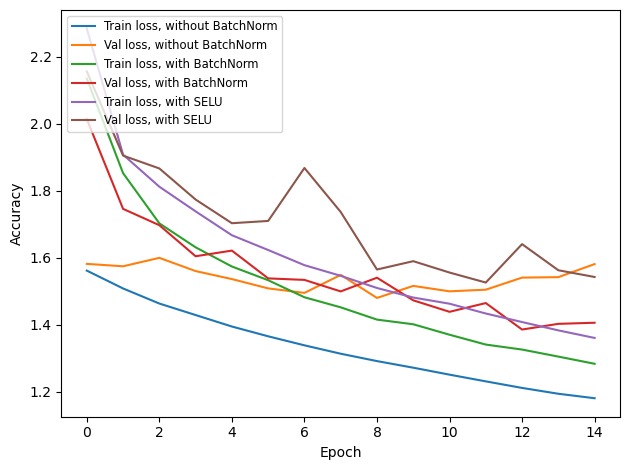

In [32]:
plt.plot(np.arange(len(history_train_all[0][:15])), history_train_all[0][:15], label='Train loss, without BatchNorm')
plt.plot(np.arange(len(history_val_all[0][:15])), history_val_all[0][:15], label='Val loss, without BatchNorm')

plt.plot(np.arange(len(history_train_all[1][:15])), history_train_all[1][:15], label='Train loss, with BatchNorm')
plt.plot(np.arange(len(history_val_all[1][:15])), history_val_all[1][:15], label='Val loss, with BatchNorm')

plt.plot(np.arange(len(history_train_all[2][:15])), history_train_all[2][:15], label='Train loss, with SELU')
plt.plot(np.arange(len(history_val_all[2][:15])), history_val_all[2][:15], label='Val loss, with SELU')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.legend(loc='upper left', fontsize='small')
plt.show()

In [45]:
class CifarDNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(n_inputs, n_hidden, device=device))
        self.layers.append(nn.SELU())
        self.layers.append(nn.AlphaDropout(p=0.05))
        for i in range(20):
            self.layers.append(nn.Linear(n_hidden, n_hidden, device=device))
            self.layers.append(nn.SELU())
            self.layers.append(nn.AlphaDropout(p=0.05))
        self.layers.append(nn.Linear(n_hidden, n_outputs))

    def forward(self, x):
        for layers in self.layers:
            x = layers(x)
        return x
    
def init_weights_he(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='linear')
        #nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = CifarDNN(3*32*32, 50, 10).to(device)
model.apply(init_weights_he)

optimizer = optim.NAdam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopping(patience=4)

history_train, history_val = train(model, optimizer, criterion, 50, train_loader, val_loader)
history_train_all.append(history_train)
history_val_all.append(history_val)

Epoch 1/50 | Train loss: 2.1283, Train accuracy: 0.2012 |               Val loss: 2.0656 | Val accuracy: 0.2203
Epoch 2/50 | Train loss: 1.9751, Train accuracy: 0.2487 |               Val loss: 2.1221 | Val accuracy: 0.2658
Epoch 3/50 | Train loss: 1.9243, Train accuracy: 0.2687 |               Val loss: 2.2209 | Val accuracy: 0.2544
Epoch 4/50 | Train loss: 1.8868, Train accuracy: 0.2837 |               Val loss: 2.2099 | Val accuracy: 0.3226
Epoch 5/50 | Train loss: 1.8772, Train accuracy: 0.2911 |               Val loss: 2.4725 | Val accuracy: 0.3204
Epoch 6/50 | Train loss: 1.8046, Train accuracy: 0.3288 |               Val loss: 2.5322 | Val accuracy: 0.3024
Epoch 7/50 | Train loss: 1.7666, Train accuracy: 0.3457 |               Val loss: 2.0241 | Val accuracy: 0.3441
Epoch 8/50 | Train loss: 1.7415, Train accuracy: 0.3567 |               Val loss: 2.4381 | Val accuracy: 0.3163
Epoch 9/50 | Train loss: 1.7212, Train accuracy: 0.3674 |               Val loss: 2.8360 | Val accuracy:

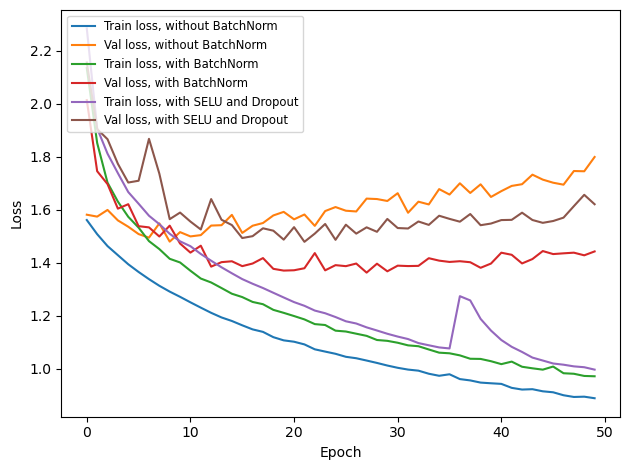

In [ ]:
plt.plot(np.arange(len(history_train_all[0])), history_train_all[0], label='Train loss, without BatchNorm')
plt.plot(np.arange(len(history_val_all[0])), history_val_all[0], label='Val loss, without BatchNorm')

plt.plot(np.arange(len(history_train_all[1])), history_train_all[1], label='Train loss, with BatchNorm')
plt.plot(np.arange(len(history_val_all[1])), history_val_all[1], label='Val loss, with BatchNorm')

plt.plot(np.arange(len(history_train_all[3])), history_train_all[3], label='Train loss, with SELU and Dropout')
plt.plot(np.arange(len(history_val_all[3])), history_val_all[3], label='Val loss, with SELU and Dropout')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend(loc='upper left', fontsize='small')
plt.show()

In [61]:
X_new = next(iter(val_loader))
X_batch, y_batch = X_new
X_batch.shape, y_batch.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64]))

In [65]:
X_new.shape

torch.Size([2, 3, 32, 32])

In [66]:
model.eval()
for module in model.modules():
    if isinstance(module, nn.Dropout):
        module.train()


X = next(iter(val_loader))
X_batch, y_batch = X
X_new = X_batch[:3]
X_new = X_new.to(device)

torch.manual_seed(42)
with torch.no_grad():
    X_new_repeated = X_new.repeat_interleave(100, dim=0)
    y_logits_all = model(X_new_repeated).reshape(3, 100, 10)
    y_probas_all = torch.nn.functional.softmax(y_logits_all, dim=-1)
    y_probas = y_probas_all.mean(dim=1)

In [67]:
y_probas.round(decimals=2)

tensor([[0.6000, 0.0000, 0.4000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0700, 0.0000, 0.2100, 0.0000, 0.7200, 0.0000, 0.0000,
         0.0000],
        [0.0100, 0.0000, 0.2800, 0.0300, 0.4100, 0.0300, 0.2200, 0.0200, 0.0000,
         0.0000]], device='mps:0')

In [75]:
def train_with_scheduler(model, optimizer, scheduler, criterion, epochs, train_loader, val_loader):

    history_train_loss = []
    history_val_loss = []
    # history_train_acc = []
    # history_val_acc = []

    for epoch in range(epochs):

        model.train()
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        for X_batch, y_batch in train_loader:

            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy(preds, y_batch)

        scheduler.step()

        train_loss /= len(train_loader) 
        train_acc /= len(train_loader) 

        model.eval()
        for X_batch, y_batch in val_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with torch.no_grad():
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                val_loss += loss.item()
                val_acc += accuracy(preds, y_batch)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f} | Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}")
        
        history_train_loss.append(train_loss)
        history_val_loss.append(val_loss)
        # history_train_acc.append()
        # history_val_acc.append()

    print("Training finished.")
    return history_train_loss, history_val_loss

class CifarDNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Flatten())
        self.layers.append(nn.Linear(n_inputs, n_hidden, device=device))
        self.layers.append(nn.SELU())
        self.layers.append(nn.AlphaDropout(p=0.05))
        for i in range(20):
            self.layers.append(nn.Linear(n_hidden, n_hidden, device=device))
            self.layers.append(nn.SELU())
            self.layers.append(nn.AlphaDropout(p=0.05))
        self.layers.append(nn.Linear(n_hidden, n_outputs))

    def forward(self, x):
        for layers in self.layers:
            x = layers(x)
        return x
    
def init_weights_he(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=1.0 / np.sqrt(m.weight.shape[1]))
        #nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model = CifarDNN(3*32*32, 50, 10).to(device)
model.apply(init_weights_he)

optimizer = optim.NAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.003, epochs=50, steps_per_epoch=len(train_loader))
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopping(patience=4)

history_train, history_val = train_with_scheduler(model, optimizer, scheduler, criterion, 50, train_loader, val_loader)
history_train_all.append(history_train)
history_val_all.append(history_val)

Epoch 1/50 | Train loss: 2.3006, Train accuracy: 0.1538 | Val loss: 2.1352 | Val accuracy: 0.2085
Epoch 2/50 | Train loss: 2.1274, Train accuracy: 0.1940 | Val loss: 2.0495 | Val accuracy: 0.2369
Epoch 3/50 | Train loss: 2.0539, Train accuracy: 0.2138 | Val loss: 1.9746 | Val accuracy: 0.2369
Epoch 4/50 | Train loss: 2.0153, Train accuracy: 0.2268 | Val loss: 1.9667 | Val accuracy: 0.2563
Epoch 5/50 | Train loss: 1.9859, Train accuracy: 0.2333 | Val loss: 1.9551 | Val accuracy: 0.2409
Epoch 6/50 | Train loss: 1.9668, Train accuracy: 0.2405 | Val loss: 1.9390 | Val accuracy: 0.2593
Epoch 7/50 | Train loss: 1.9462, Train accuracy: 0.2500 | Val loss: 1.9243 | Val accuracy: 0.2720
Epoch 8/50 | Train loss: 1.9274, Train accuracy: 0.2530 | Val loss: 1.9200 | Val accuracy: 0.2795
Epoch 9/50 | Train loss: 1.9104, Train accuracy: 0.2647 | Val loss: 1.8970 | Val accuracy: 0.2595
Epoch 10/50 | Train loss: 1.8977, Train accuracy: 0.2695 | Val loss: 1.9022 | Val accuracy: 0.2907
Epoch 11/50 | Train

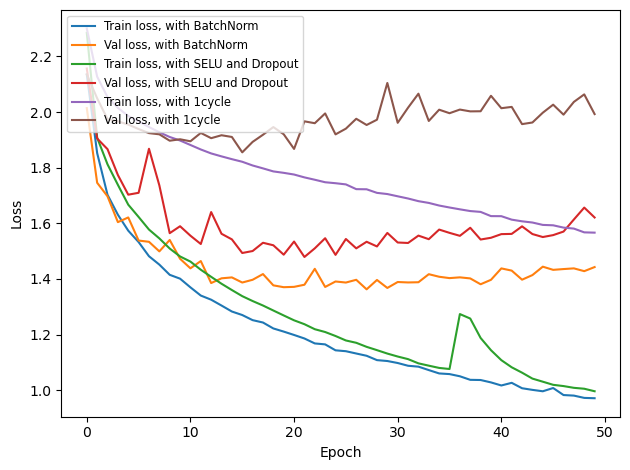

In [76]:
plt.plot(np.arange(len(history_train_all[1])), history_train_all[1], label='Train loss, with BatchNorm')
plt.plot(np.arange(len(history_val_all[1])), history_val_all[1], label='Val loss, with BatchNorm')

plt.plot(np.arange(len(history_train_all[2])), history_train_all[2], label='Train loss, with SELU and Dropout')
plt.plot(np.arange(len(history_val_all[2])), history_val_all[2], label='Val loss, with SELU and Dropout')

plt.plot(np.arange(len(history_train_all[5])), history_train_all[5], label='Train loss, with 1cycle')
plt.plot(np.arange(len(history_val_all[5])), history_val_all[5], label='Val loss, with 1cycle')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend(loc='upper left', fontsize='small')
plt.show()